# Creating Custom Compartmental Models: SIR Tutorial

In this tutorial, we'll build a custom **SIR (Susceptible-Infectious-Recovered)** model from scratch to understand:

1. **Model Architecture**: How compartmental models are structured in simcronomicon
2. **Parameter Design**: Defining model-specific parameters with validation
3. **Agent Behavior**: Implementing disease progression and interaction logic
4. **Testing & Validation**: Comparing with mathematical models
5. **Advanced Features**: Extensions like behavioral interventions

**Why SIR?** It's the simplest epidemic model but teaches all the core concepts needed to build any compartmental model!

In [55]:
import simcronomicon as scon
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import os
import random as rd
import os
import glob

## Step 1: Understanding SIR vs SEIR

Let's compare the SIR model we'll build with the existing SEIR model:

**SIR Model:**
- **S** → **I** → **R** (3 compartments)
- Parameters: β (transmission), γ (recovery time)
- Simpler but captures core epidemic dynamics

**SEIR Model (existing):**
- **S** → **E** → **I** → **R** (4 compartments) 
- Parameters: β (transmission), σ (incubation), γ (recovery time)
- More realistic with incubation period

## Step 2: Define SIR Model Parameters

Every compartmental model needs a parameters class that inherits from `AbstractModelParameters`.
This class handles validation and metadata for simulation persistence.

In [56]:
from simcronomicon.compartmental_models.abstract_model import AbstractModelParameters

class SIRModelParameters(AbstractModelParameters):
    """
    Parameters for the SIR compartmental model.
    
    Parameters
    ----------
    max_energy : int
        Maximum daily energy for agents (affects movement)
    beta : float
        Transmission rate - probability of infection per contact (0-1)
    gamma : float  
        Recovery time - days until recovery from infectious status
    """
    
    def __init__(self, max_energy, beta, gamma):
        super().__init__(max_energy)
        
        # Validate parameters - this is crucial!
        assert isinstance(beta, (int, float)) and 0 <= beta <= 1, \
            "beta must be between 0 and 1"
        assert isinstance(gamma, (int, float)) and gamma > 0, \
            "gamma must be positive"
        
        self.beta = beta
        self.gamma = gamma
    
    def to_metadata_dict(self):
        """Convert parameters to dictionary for saving simulations."""
        return {
            'max_energy': self.max_energy,
            'beta': self.beta,
            'gamma': self.gamma,
            'model_type': 'SIR'
        }

## Step 3: Create SIR Agent Class

The agent class (FolkSIR) defines how individuals behave and transition between disease states.
Key methods:
- `interact()`: Handle disease transmission between agents
- `sleep()`: End-of-day processing and disease progression

In [57]:
from simcronomicon.compartmental_models.abstract_model import AbstractFolk

class FolkSIR(AbstractFolk):
    """
    SIR agent with disease-specific behaviors.
    """
    
    def interact(self, folks_here, current_place_type, status_dict_t, model_params, dice):
        """
        Handle agent interactions - disease transmission happens here!
        """
        # Only susceptible agents can become infected
        if self.status == 'S':
            # Count infectious people at this location
            num_infectious = len([
                folk for folk in folks_here 
                if folk != self and folk.status == 'I'
            ])
            
            if num_infectious > 0:
                # Calculate transmission probability using inverse Bernoulli
                # This handles multiple infectious contacts realistically
                transmission_prob = self.inverse_bernoulli(
                    num_infectious, 
                    model_params.beta / len(folks_here)
                )
                
                # Attempt infection
                if transmission_prob > dice:
                    self.convert('I', status_dict_t)
        
        # Reduce energy from social interaction
        if self.energy > 0:
            self.energy -= 1
    
    def sleep(
            self,
            folks_here,
            current_place_type,
            status_dict_t,
            model_params,
            dice):
        """
        End-of-day processing: energy reset and disease progression.
        """
        # Call parent sleep (resets energy, increments status_step_streak)
        super().sleep()
        
        # Disease progression: I → R after gamma days
        if self.status == 'I' and self.status_step_streak >= model_params.gamma:
            self.convert('R', status_dict_t)

## Step 4: Implement the SIR Model Class

The model class coordinates everything and inherits from `AbstractCompartmentalModel`.
**Critical**: Define model attributes BEFORE calling `super().__init__()`

In addition, every custom model must override the `initialize_sim_population` method to handle initial status assignments.
This method determines:
- How many agents start in each compartment
- Where agents are initially located
- Initial status counts for tracking

In [58]:
from simcronomicon.compartmental_models.abstract_model import AbstractCompartmentalModel

class SIRModel(AbstractCompartmentalModel):
    
    def __init__(self, model_params, step_events=None):
        # IMPORTANT: Define these BEFORE calling super().__init__()
        self.infected_statuses = ['I']  # Only infectious status
        self.all_statuses = ['S', 'I', 'R']  # All possible statuses
        self.folk_class = FolkSIR  # Agent class to use
        self.step_events = step_events  # Custom or default events
        
        # Initialize parent class (validates our definitions)
        super().__init__(model_params)
    
    def initialize_sim_population(self, town):
        num_pop, num_init_spreader, num_init_spreader_rd, folks, household_node_indices, assignments = super().initialize_sim_population(town)
        
        for i in range(num_init_spreader_rd):
            node = rd.choice(town.accommodation_node_ids)
            assignments.append((node, 'I'))  # Start as Infectious
        
        for i in range(num_pop - num_init_spreader):
            node = rd.choice(town.accommodation_node_ids)
            assignments.append((node, 'S'))  # Start as Susceptible
        
        for node in town.town_params.spreader_initial_nodes:
            assignments.append((node, 'I'))
        
        for i, (node, status) in enumerate(assignments):
            folk = self.create_folk(i, node, self.model_params.max_energy, status)
            folks.append(folk)
            town.town_graph.nodes[node]["folks"].append(folk)
            
            # Track household nodes (nodes with 2+ people)
            if len(town.town_graph.nodes[node]["folks"]) == 2:
                household_node_indices.add(node)
        
        # Create initial status dictionary for timestep 0
        status_dict_t0 = {
            'current_event': None,
            'timestep': 0,
            'S': num_pop - num_init_spreader,  # Susceptible count
            'I': num_init_spreader,            # Infectious count  
            'R': 0                             # Recovered count (starts at 0)
        }
        
        return folks, household_node_indices, status_dict_t0

## Step 5: Test Your SIR Model

Let's create a simple test to validate our implementation works correctly.
We'll create a small town and run a short simulation.

In [59]:
# Create a simple town
point = (50.7753, 6.0839)
town_params = scon.TownParameters(1000, 100)
town = scon.Town.from_point(point, 500, town_params)

# Configure SIR model
sir_params = SIRModelParameters(
    max_energy=5,
    beta=0.3,      # 30% transmission probability
    gamma=7        # Recovery after 7 days
)

# Create model and simulation
sir_model = SIRModel(sir_params) # Use default step_events
simulation = scon.Simulation(town, sir_model, timesteps=100)

# Run simulation
print("Running SIR simulation...")
simulation.run(silent=True)

[1/10] Initializing town object and parameters...
[2/10] Calculating EPSG code...
[3/10] Downloading OSM road network and building data...
[4/10] Processing building geometries...
[5/10] Matching building centroids to nearest road nodes...
[6/10] Classifying buildings...
[7/10] Annotating road graph with place types...
[8/10] Filtering out irrelevant nodes...
[9/10] Building town graph...
Computing shortest paths between filtered nodes...
Adding edges to final town graph...


100%|██████████| 273/273 [00:00<00:00, 6694.25it/s]

[10/10] Saving a compressed graph and metadata...


Town graph successfully built and saved!
Running SIR simulation...


**You can still use our visualization function with your custom compartmental model**

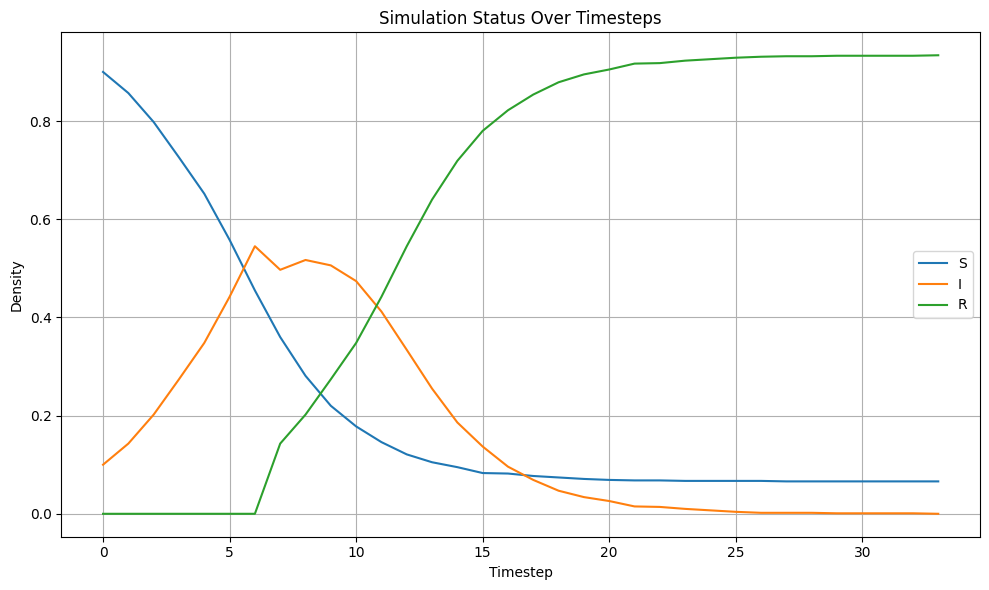

In [60]:
scon.plot_status_summary_from_hdf5("simulation_output.h5")

In [61]:
scon.visualize_folks_on_map_from_sim("simulation_output.h5", "town_graph.graphmlz")

File clean up blog

In [62]:
file_patterns = ["*.json", "*.graphmlz", "simulation_output.h5"]

removed_count = 0
for pattern in file_patterns:
    matching_files = glob.glob(pattern)
    for file_path in matching_files:
        try:
            os.remove(file_path)
            print(f"Removed: {file_path}")
            removed_count += 1
        except Exception as e:
            print(f"Failed to remove {file_path}: {e}")

Removed: town_graph_config.json
Removed: town_graph.graphmlz
Removed: simulation_output.h5
